**Logistic Regression Pipeline**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from time import time

In [3]:
from sklearn.svm import LinearSVC, SVC
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.utils.multiclass import unique_labels

In [4]:
hotels=pd.read_csv("data/reviews_mod5.csv")

In [5]:
hotels = hotels.drop(hotels.columns[0], axis=1)

__Function Definitions__

In [6]:
def split_train_test_data(input_data, target, ratio=0.3, rand_state=42):
    return train_test_split(input_data, target, test_size=ratio, stratify=target, random_state=rand_state)

def apply_grid_search_cv(pipe, param_grid, X_train, y_train, X_test, y_test, print_flag=True, score_matrix=f1_score, n_jobs=-1, cv=5):
    grid_search = GridSearchCV(pipe, param_grid=param_grid, scoring=make_scorer(score_matrix), n_jobs=n_jobs, cv=cv)
    t0 = time()
    res = grid_search.fit(X_train, y_train)
    if print_flag:
        print("done in %0.3fs" % (time() - t0))
        print("best params:")
        print(res.best_params_)
        print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
        print("Test-set score: {:.3f}".format(grid_search.score(X_test, y_test)))   
    return grid_search

def save_class_report_cv(grid_search, X_test, y_test, target_names, filename):
    y_pred = grid_search.best_estimator_.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(filename)
    return df

In [7]:
def save_cross_validation_results(grid_search, filename, print_flag=True):
    param_keys = list(grid_search.cv_results_["params"][0].keys())
    matrix_list = ["mean_test_score", "std_test_score", "rank_test_score", "mean_fit_time"] 
    col = param_keys + matrix_list

    cv_results = []
    cv_results.append(col)    
    
    for param, score, std, rank, time in zip(grid_search.cv_results_["params"], grid_search.cv_results_["mean_test_score"],grid_search.cv_results_["std_test_score"],
                                             grid_search.cv_results_["rank_test_score"], grid_search.cv_results_["mean_fit_time"]):
        row_item = list(param.values())
        row_item.append(score)
        row_item.append(std)
        row_item.append(rank)
        row_item.append(time)
        cv_results.append(row_item)
        
    cv_results = pd.DataFrame(cv_results) 
    header = cv_results.iloc[0] 
    cv_results = cv_results[1:]
    cv_results = cv_results.rename(columns = header)
    cv_results = cv_results.sort_values(by=['rank_test_score'])
    cv_results.to_csv(filename)
    if print_flag:
        print(cv_results.head(6))
   #     print(cv_results.tail(6))

__1. Choose input data and target__

In [8]:
X = hotels["norm"]
y = hotels["deceptive"]

__2. Split data__

In [9]:
X_train, X_test, y_train, y_test = split_train_test_data(X, y)

__3. Build pipeline__

In [10]:
steps_lr = [
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
]

pipe_lr = Pipeline(steps_lr)

__4. Construct parameters for cross validation testing__

In [11]:
param_grid_lr = [
    {'vect__stop_words': ['english', None],
        'vect__min_df': [1, 2, 5], 
        'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
         'clf__C': [0.1, 1, 10, 100, 1000]}
]

__5. Apply Grid Serach CV__

In [12]:
log_reg_grid_search = apply_grid_search_cv(pipe_lr, param_grid_lr, X_train, y_train, X_test, y_test)

done in 66.524s
best params:
{'clf__C': 1000, 'vect__min_df': 2, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}
Best cross-validation score: 0.878
Test-set score: 0.902


C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


__6. Save Reports to File__

In [13]:
save_cross_validation_results(log_reg_grid_search, "output/log_reg_norm1_validation_res.csv", True)

   clf__C vect__min_df vect__ngram_range vect__stop_words mean_test_score  \
82   1000            2            (1, 2)             None        0.878242   
84   1000            2            (1, 3)             None        0.877947   
35      1            5            (1, 3)          english        0.875016   
64    100            2            (1, 2)             None        0.874494   
47     10            2            (1, 3)          english        0.874472   
66    100            2            (1, 3)             None        0.874053   

   std_test_score rank_test_score mean_fit_time  
82      0.0190659               1      0.772182  
84      0.0232352               2       1.50722  
35      0.0185063               3      0.821003  
64       0.018163               4      0.727654  
47      0.0172921               5      0.868284  
66       0.017291               6       1.48066  


In [14]:
save_class_report_cv(log_reg_grid_search, X_test, y_test, ["truthful", "deceptive"], "output/log_reg_norm1_report.csv")

,f1-score,precision,recall,support
truthful,0.897872,0.917391,0.879167,240.0
deceptive,0.902041,0.884000,0.920833,240.0
micro avg,0.900000,0.900000,0.900000,480.0
macro avg,0.899957,0.900696,0.900000,480.0
weighted avg,0.899957,0.900696,0.900000,480.0


__7. Save model to file__

In [15]:
from sklearn.externals import joblib
joblib.dump(log_reg_grid_search.best_estimator_, 'output/log_reg_norm1.pkl')

['output/log_reg_norm1.pkl']

__7b. Identify important features for deceptive opinion spam__

In [33]:
vectorizer = log_reg_grid_search.best_estimator_.named_steps["vect"]
tfidf = log_reg_grid_search.best_estimator_.named_steps["tfidf"]

# transform the training dataset
X_train1 = vectorizer.transform(X_train)
X_train1 = tfidf.transform(X_train1)

max_value = X_train1.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['to hit' 'chosen for' 'should say' 'show our' 'chinese restaurant'
 'shower really' 'shower tub' 'showers oh' 'whichworked' 'whichworked out'
 'sight the' 'sign of' 'chicago best' 'chi town' 'checkout the'
 'treated well' 'should at' 'charge us' 'shortage of' 'claimed on']
Features with highest tfidf: 
['cd' 'hilton' 'children' 'compared to' 'compared' 'the construction'
 'my wedding' 'yeah' 'our guests' 'cab' 'garage' 'deal' 'cousin'
 'my cousin' 'mother' 'computers' 'avoid' 'affina' 'policy' 'yellow']


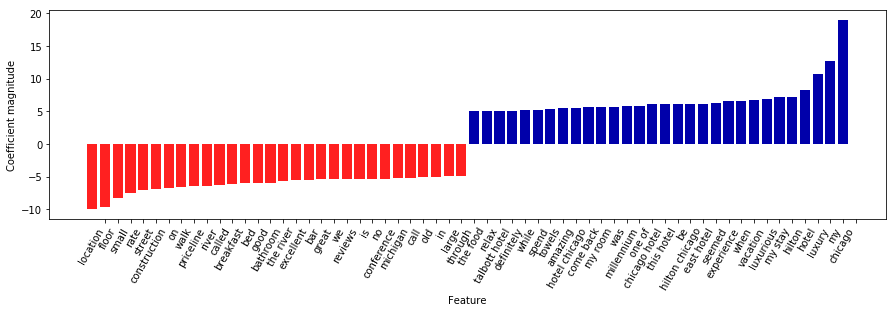

In [34]:
import mglearn

mglearn.tools.visualize_coefficients(
    log_reg_grid_search.best_estimator_.named_steps["clf"].coef_,
    feature_names, n_top_features=30)

__Observation:__ The negative coefficients on the left belong to words that represent negative "deceptions", ie. truthful reviews. While the positive coefficients represent deceptive reviews.
Since the best estimator chosen by the grid search did not include stop words, we can see some common stop words being included, i.e on, we, is etc. 
The difference between the left and the right are subtle, but we can see the truthful reviews (on the left) has more simple and specific words, such as location, floor, small, river etc, while the deceptive reviews (on the right) has more extravagent words like "luxury", "luxurious", "amazing", "experience" etc, as well as more mentions of hotel, hotel names and "Chicago".

__8. Sentiment Analysis__

In [23]:
y = hotels["polarity"]
X_train, X_test, y_train, y_test = split_train_test_data(X, y)
log_reg_grid_search_p = apply_grid_search_cv(pipe_lr, param_grid_lr, X_train, y_train, X_test, y_test)

done in 68.736s
best params:
{'clf__C': 1000, 'vect__min_df': 2, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}
Best cross-validation score: 0.956
Test-set score: 0.962


C:\Users\Susan\Anaconda3\envs\thesis\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [24]:
save_cross_validation_results(log_reg_grid_search_p, "output/log_reg_norm1_sent_validation_res.csv")

   clf__C vect__min_df vect__ngram_range vect__stop_words mean_test_score  \
82   1000            2            (1, 2)             None          0.9558   
72    100            5            (1, 3)             None        0.955158   
70    100            5            (1, 2)             None        0.954152   
90   1000            5            (1, 3)             None        0.953249   
88   1000            5            (1, 2)             None        0.953118   
64    100            2            (1, 2)             None        0.952962   

   std_test_score rank_test_score mean_fit_time  
82      0.0134669               1      0.773156  
72      0.0124381               2       1.43835  
70      0.0134553               3      0.689483  
90      0.0134161               4       1.39993  
88      0.0157598               5      0.716118  
64      0.0142242               6      0.758571  


In [25]:
save_class_report_cv(log_reg_grid_search_p, X_test, y_test, ["negative", "positive"], "output/log_re_norm1_report_sent.csv")

,f1-score,precision,recall,support
negative,0.962963,0.951220,0.9750,240.0
positive,0.962025,0.974359,0.9500,240.0
micro avg,0.962500,0.962500,0.9625,480.0
macro avg,0.962494,0.962789,0.9625,480.0
weighted avg,0.962494,0.962789,0.9625,480.0


In [26]:
from sklearn.externals import joblib
joblib.dump(log_reg_grid_search_p.best_estimator_, 'output/log_re_norm1_sent.pkl')

['output/log_re_norm1_sent.pkl']

__8b. Identify important features for sentiment analysis__

In [29]:
vectorizer = log_reg_grid_search_p.best_estimator_.named_steps["vect"]
tfidf = log_reg_grid_search_p.best_estimator_.named_steps["tfidf"]

# transform the training dataset
X_train1 = vectorizer.transform(X_train)
X_train1 = tfidf.transform(X_train1)

max_value = X_train1.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

feature_names = np.array(vectorizer.get_feature_names())

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['in point' 'talk with' 'its way' 'of itself' 'be getting' 'didn discover'
 'several bottles' 'too but' 'were definitely' 'chaos' 'are frequent'
 'was saturday' 'account again' 'omni for' 'vinegar' 'chains' 'space to'
 'explained the' 'agreed but' 'all out']
Features with highest tfidf: 
['compared to' 'ice' 'bathrobe' 'hilton' 'the affina' 'the construction'
 '00' 'mother' 'children' 'computers' 'our guests' 'deal' 'cab' 'garage'
 'cousin' 'my cousin' 'policy' 'avoid' 'affina' 'yellow']


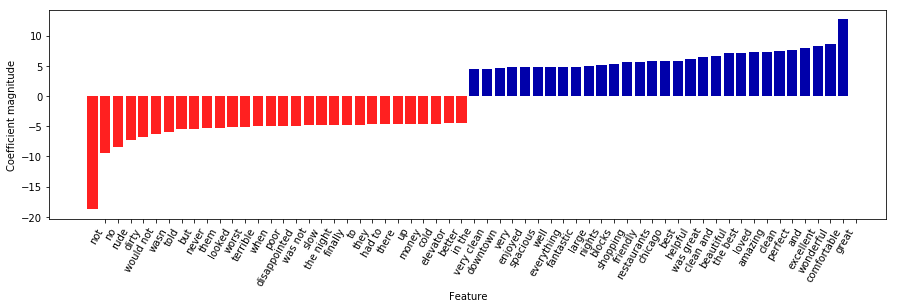

In [31]:
import mglearn

mglearn.tools.visualize_coefficients(
    log_reg_grid_search_p.best_estimator_.named_steps["clf"].coef_,
    feature_names, n_top_features=30)

__Observation:__ The negative coefficients on the left belong to words that represent negative reviews, while the positive coefficients on the right represent positive reviews. In this case the words are quite clear cut, with negative reviews featuring "not", "no" "rude", "worse", "terrribe" and "dissappointed" while the positive reviews feature "great", "comfortable", "Wonderful" and "excellent"